# AOMA with reference based Cov-SSI from STRID package

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import welch_plot, stabilization_diagram, plotModeShape, stabilization_diagram_cov_ssi
import os
import koma.oma, koma.plot
import koma.clustering
import strid
from time import time
import pandas as pd
from datetime import datetime, timedelta

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data from hdf5 file format

In [2]:
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz
bridgedeck_only = True

loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5', bridgedeck_only=bridgedeck_only)

In [3]:
print(loader.hdf5_file[loader.periods[12]]['temperature']['T01-1'].attrs['samplerate'])

0.25


In [4]:
acc = loader.load_all_acceleration_data(loader.periods[12], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)
print(len(acc[:,0]))
acc = acc[2*cutoff_frequency*60*analysis_length*4:2*cutoff_frequency*60*analysis_length*5,:]
acc = acc.transpose()
print(acc.shape)

57600
(48, 3600)


### Reference based Cov-SSI from strid-package

In [125]:
#Parameters
i = 50 #number of block rows
s = 1
fs = 2
orders = np.arange(2, 200+2, 2) #orders to perform system identification for
stabcrit = {'freq': 0.2, 'damping': 0.2, 'mac': 0.5} # Default

In [126]:
print(len(orders))

100


In [127]:
#Indices for reference channels:
"""
0-21 are channels for x-dirdction, we discard them due to assumed little excitation.
Indices [1,3,5,7,11,13,17,19] will give channels for one section of the bridge excluding towers and hangers. Add 22 and 44 respectively to get y and z direction respectively.
"""

"""
When bridge deck only channels are included, there are 16 channels in total.
Indices [0, 2, 4, 6, 8, 10, 12, 14]
"""

if bridgedeck_only:
    ix_references_y = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+16)
    ix_references_z = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+32)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()
else:
    ix_references_y = (np.array([1,3,5,7,11,13,17,19])+22)
    ix_references_z = (np.array([1,3,5,7,11,13,17,19])+44)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()



print((ix_references))

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]


In [128]:
ssid = strid.CovarianceDrivenStochasticSID(acc, fs, ix_references)

In [129]:
#Perform system identification
t0 = time()
modes = {}
for order in orders:
    A, C, G, R0 = ssid.perform(order, i)
    modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)

t1 = time()
print("Execution time = " + str(t1-t0))

Execution time = 4.811455965042114


In [130]:
#Sorting routine
#orders = []
lambdas = []
phis = []
orders_for_stabplot = []

for order in modes.keys():
    modes_in_order = modes[order]
    lambdas_in_order = []
    phis_in_order = []
    for mode in modes_in_order:
        orders_for_stabplot.append(order)
        lambdas_in_order.append(mode.eigenvalue)
        phis_in_order.append(mode.eigenvector)
    #print("lambdas: " + str(lambdas_in_order))
    #print("phis: " + str(phis_in_order))
    lambdas.append(np.array(lambdas_in_order))
    phis.append(np.array(phis_in_order).transpose())


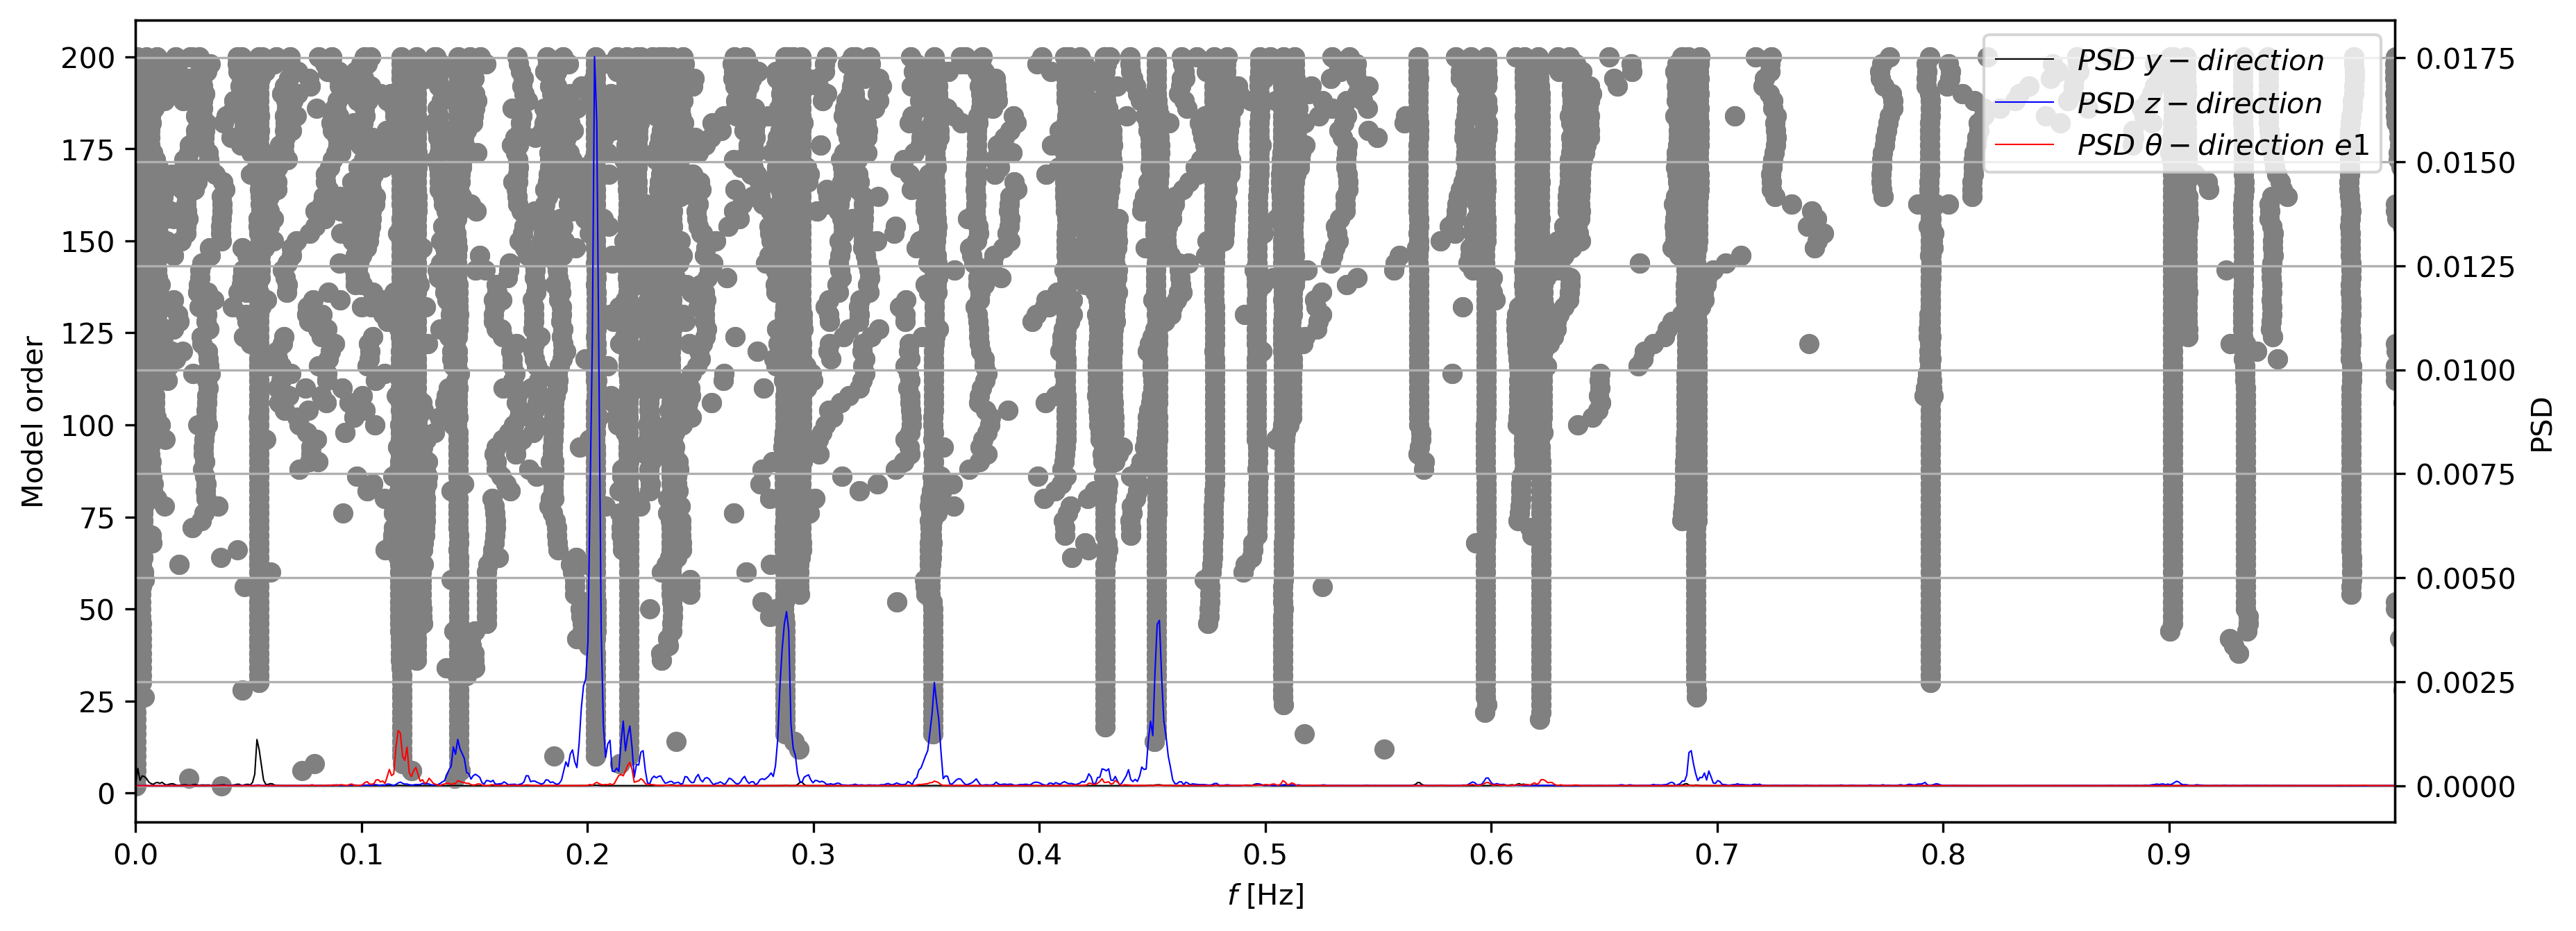

In [131]:
stab_diag = stabilization_diagram_cov_ssi(acc.transpose(), fs, 2,
                                            np.abs(np.concatenate(lambdas).ravel())/2/np.pi,
                                          np.array(orders_for_stabplot))
plt.savefig("stabilizationdiagram_cov.jpg")

In [132]:
#Find stable poles routine from KOMA package here -> doesn't quite work yet
lambd_stab, phi_stab, orders_stab, idx_stab = koma.oma.find_stable_poles(lambdas, phis, orders, s, stabcrit=stabcrit, valid_range={'freq': [0.05, np.inf], 'damping':[0, 0.2]}, indicator='freq', return_both_conjugates=False)

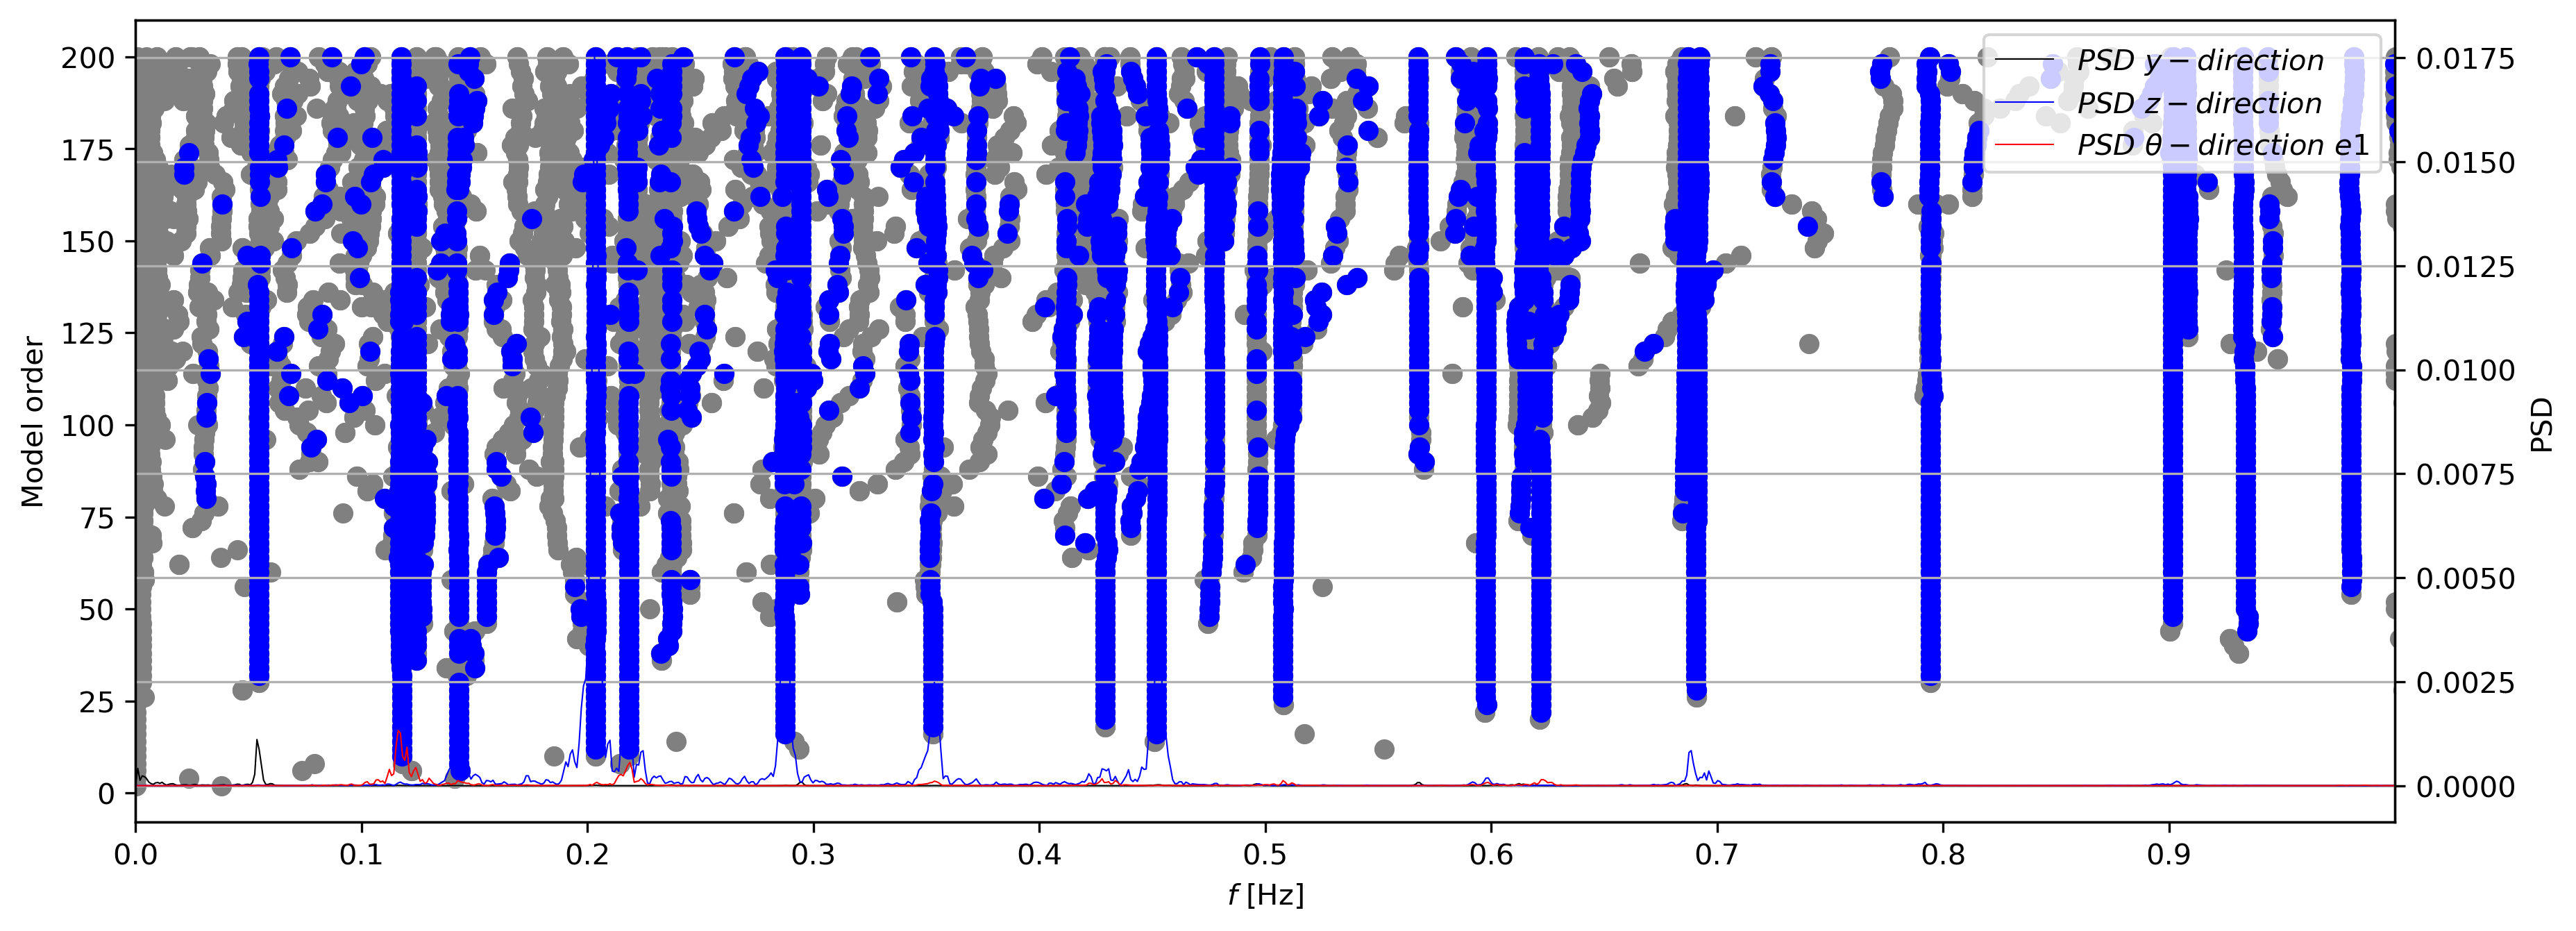

In [133]:
stab_diag = stabilization_diagram_cov_ssi(acc.transpose(), fs, 2,
                                            np.abs(np.concatenate(lambdas).ravel())/2/np.pi,
                                          np.array(orders_for_stabplot),
                                          freq_stab=np.abs(lambd_stab)/2/np.pi,
                                          orders_stab=orders_stab)
plt.savefig("stabilizationdiagram_stab.jpg")

### HDBSCAN to cluster poles from KOMA package

In [141]:
#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=50, min_samples=20, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
prob_threshold = 0.99   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.median(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.median(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

In [142]:
#Sort and arrange modeshapes
# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)

grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)

phi_extracted = np.zeros((len(grouped_phis), len(loader.acceleration_sensors)*3))

for a in range(len(grouped_phis)):
    for b in range(np.shape(grouped_phis[a])[0]):
       phi_extracted[a,b] = (np.real(np.median(grouped_phis[a][b])))

### Create stabilization diagram

/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_10850/3167269638.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc.transpose(), fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


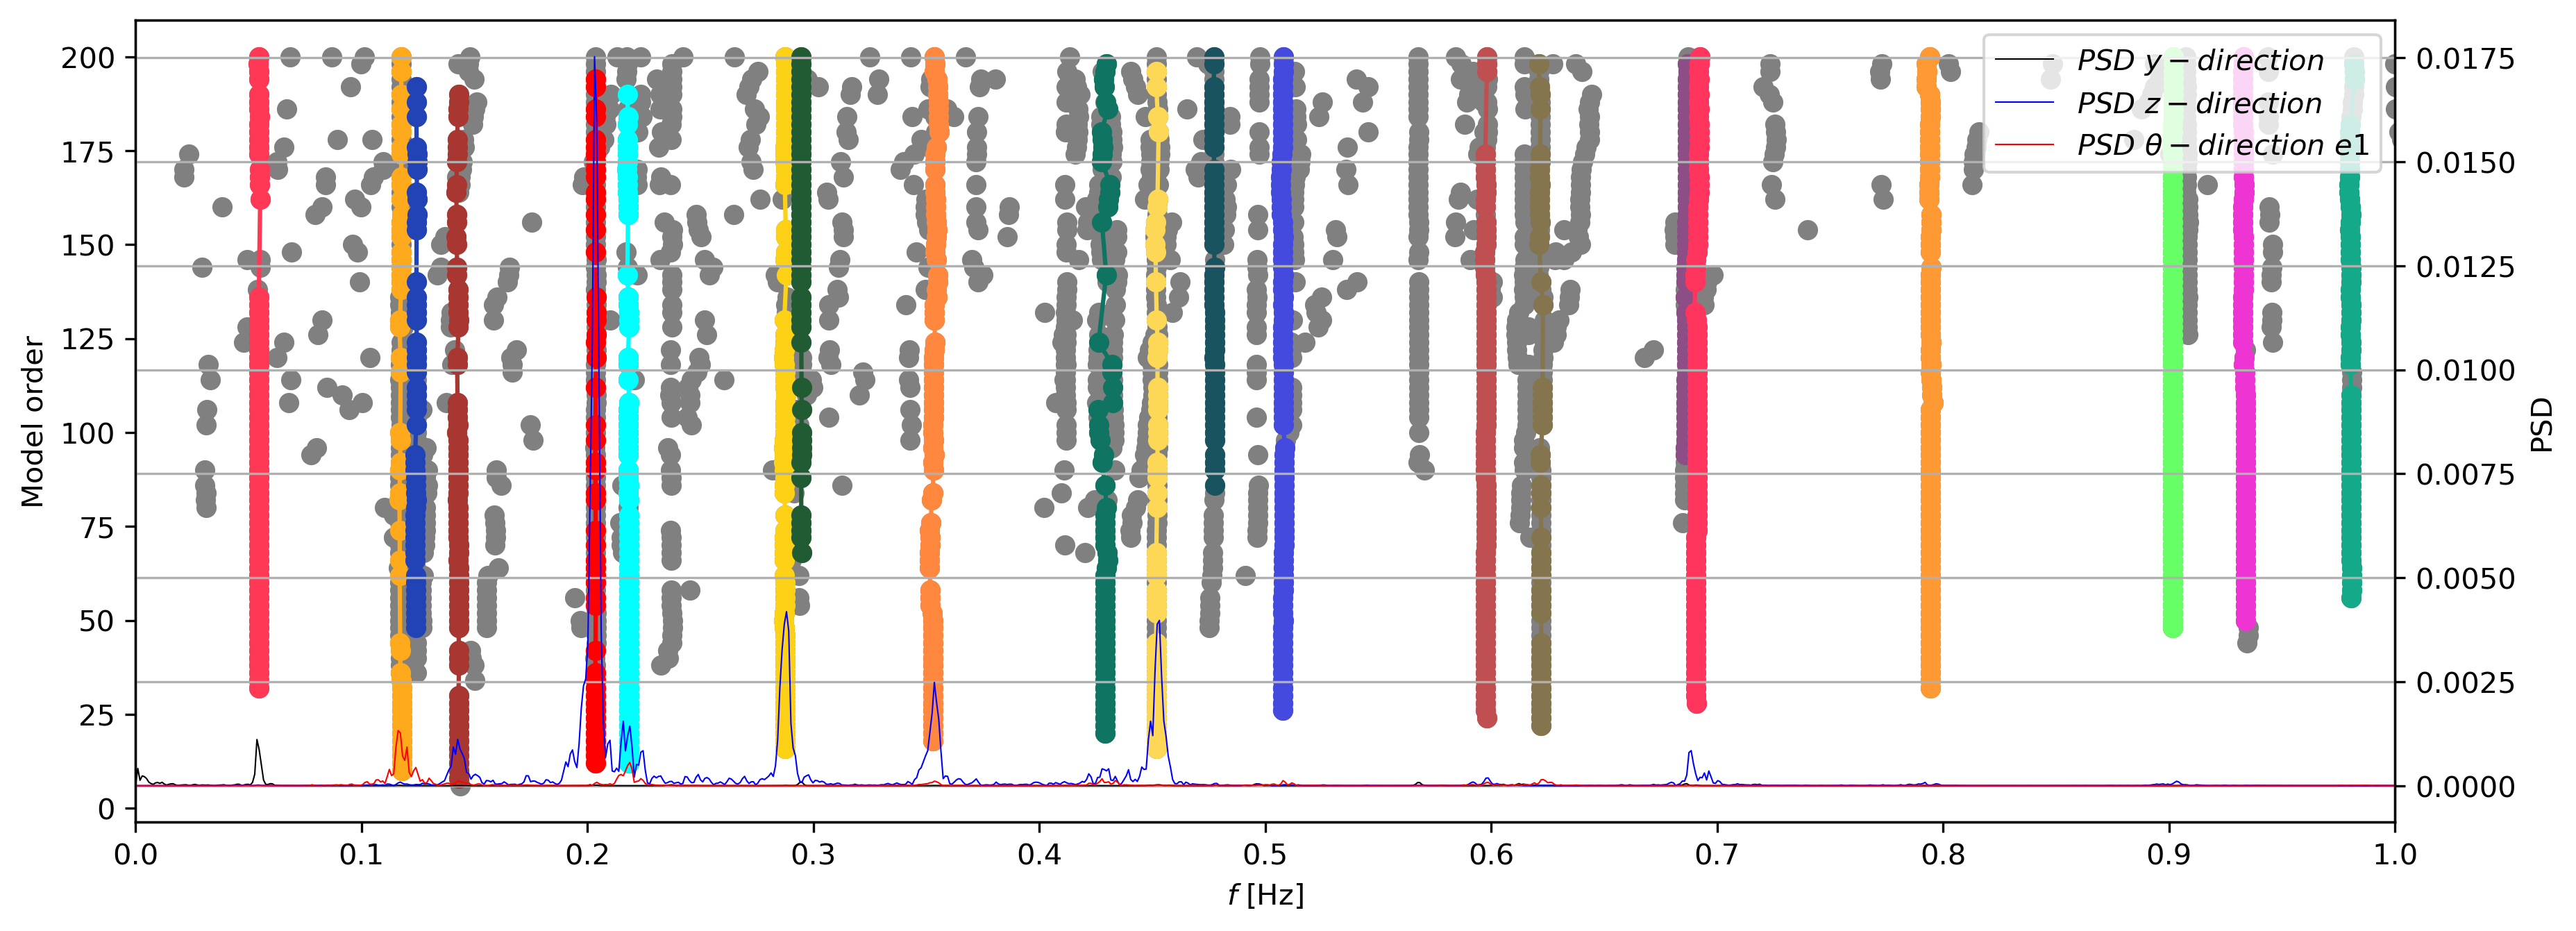

In [143]:
#Save stabilization plot
stab_diag = stabilization_diagram(acc.transpose(), fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)
plt.savefig("stabilizationdiagram_clus.jpg")

In [144]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.054612,1.563851
1,0.117580,3.094076
2,0.124272,1.377376
3,0.142890,1.179151
4,0.203571,1.078619
5,0.218316,1.005623
6,0.287439,0.565491
7,0.294599,0.150379
8,0.353184,0.726233
9,0.429127,0.971146


In [18]:
from python_appendix import OMA_functions as OMA

phi_extracted = phi_extracted.transpose()
print(phi_extracted.shape)

(48, 29)


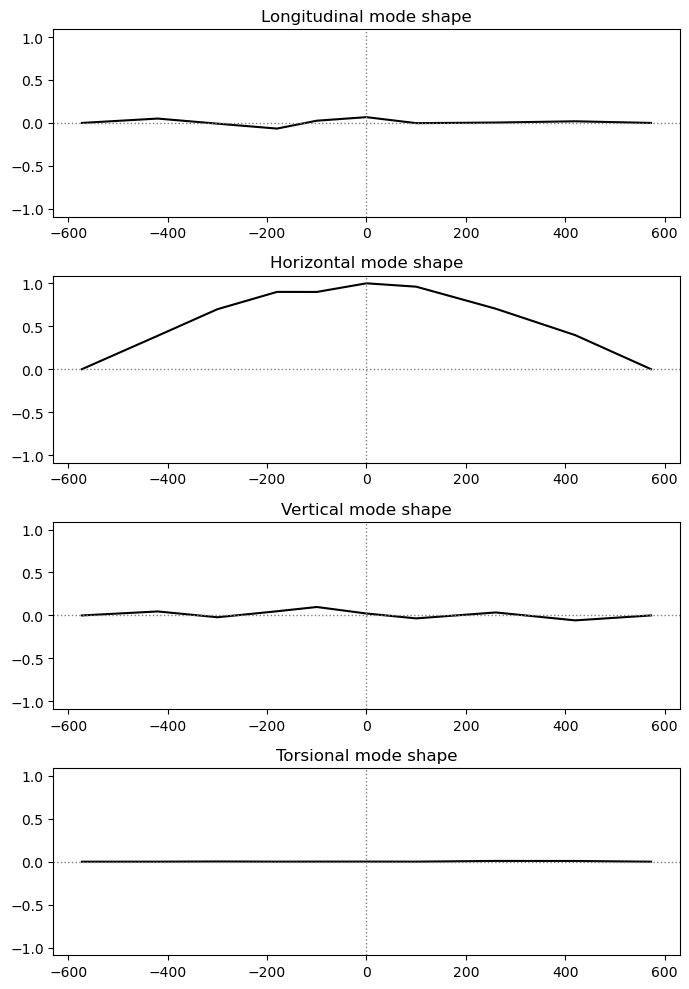

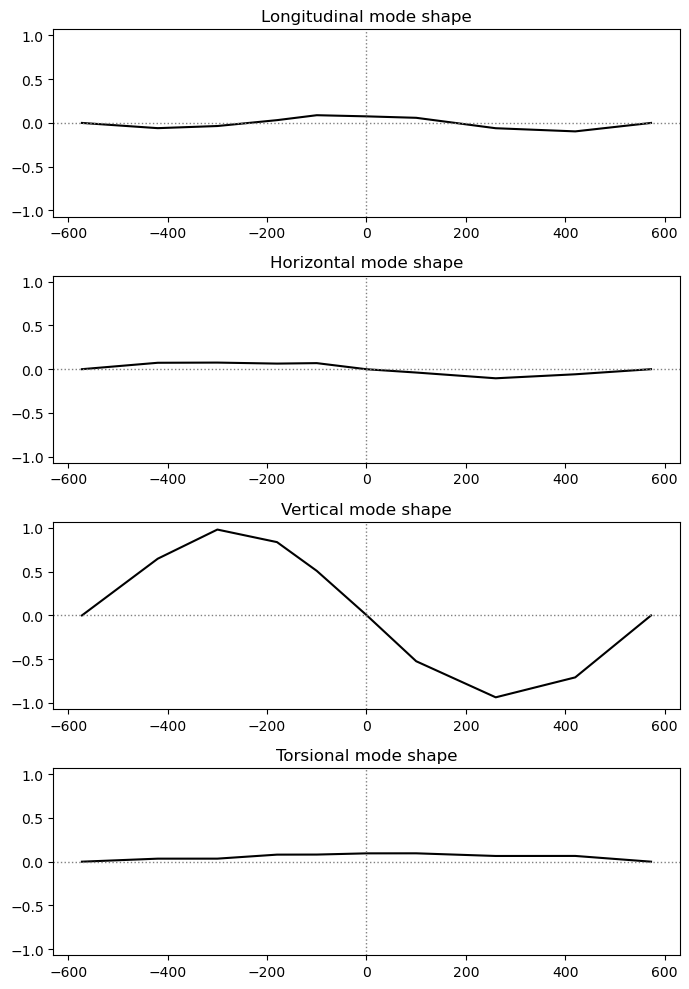

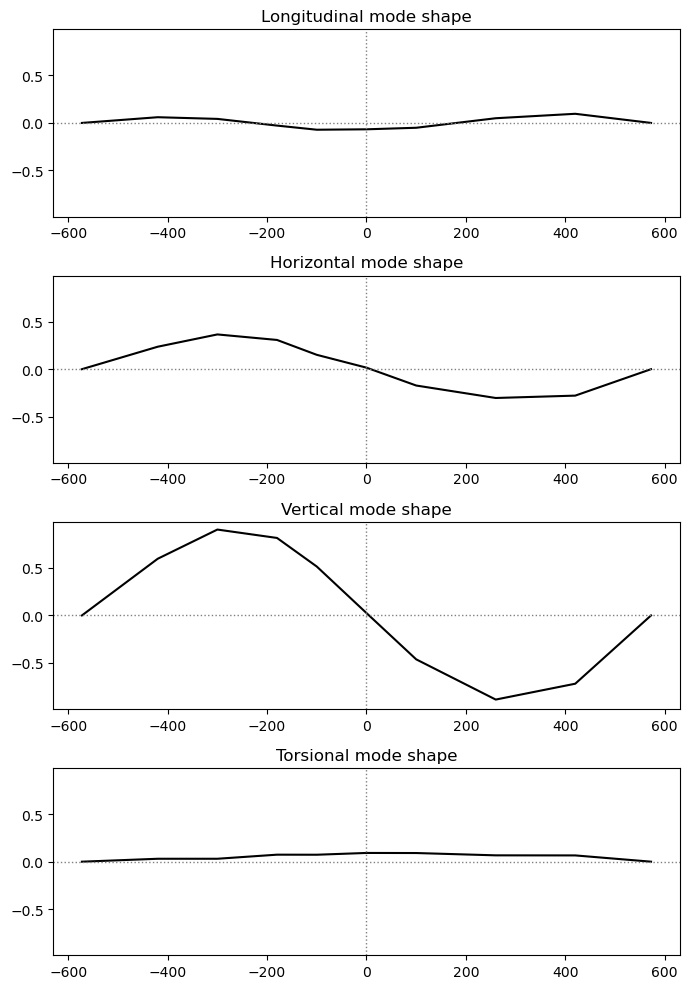

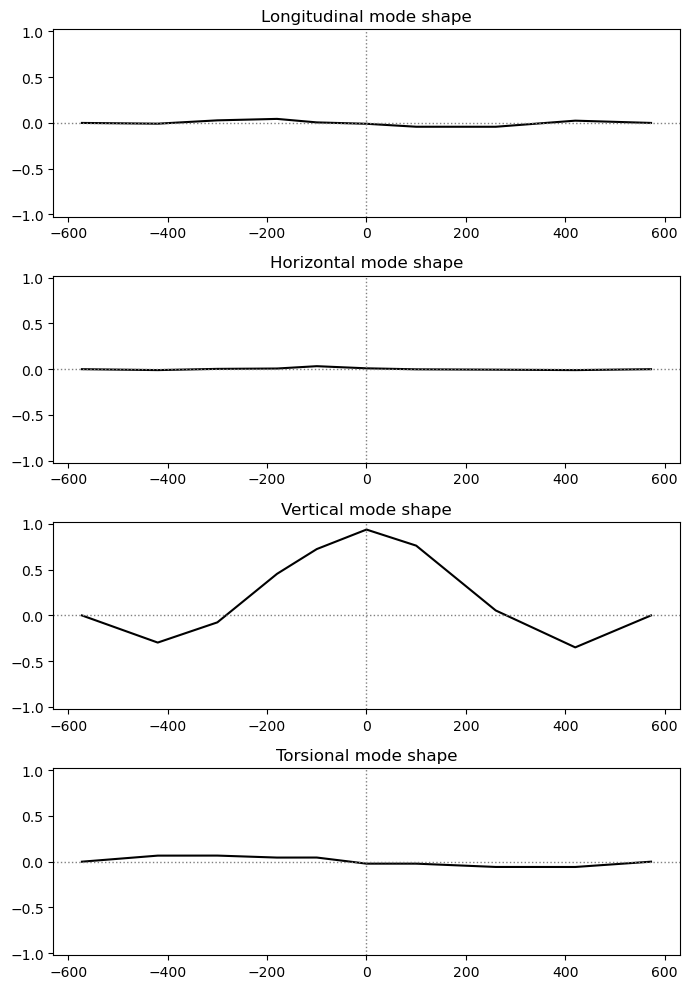

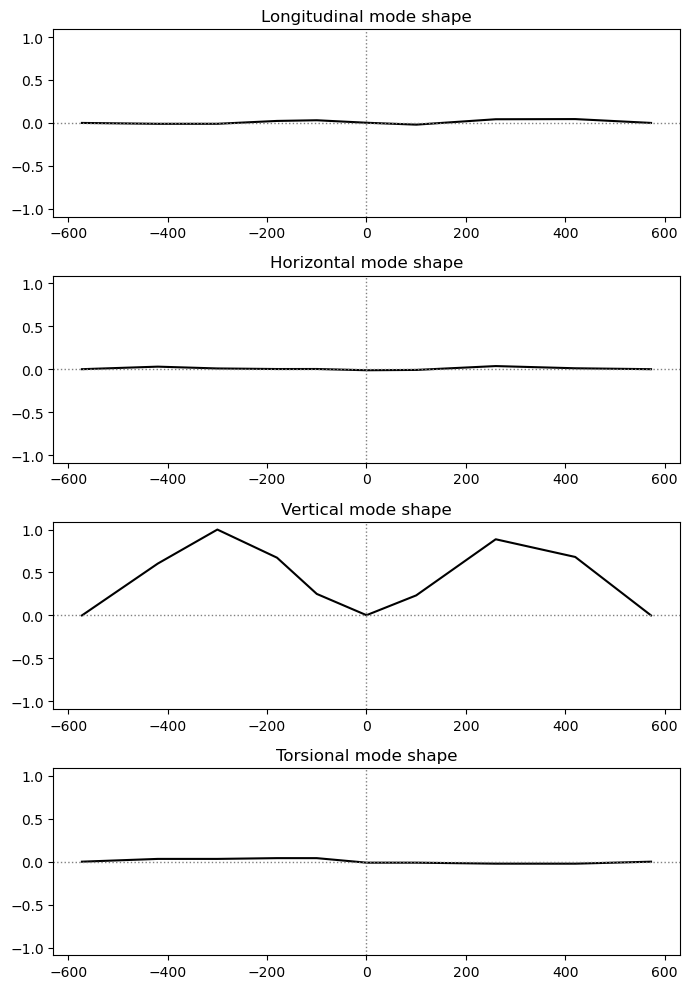

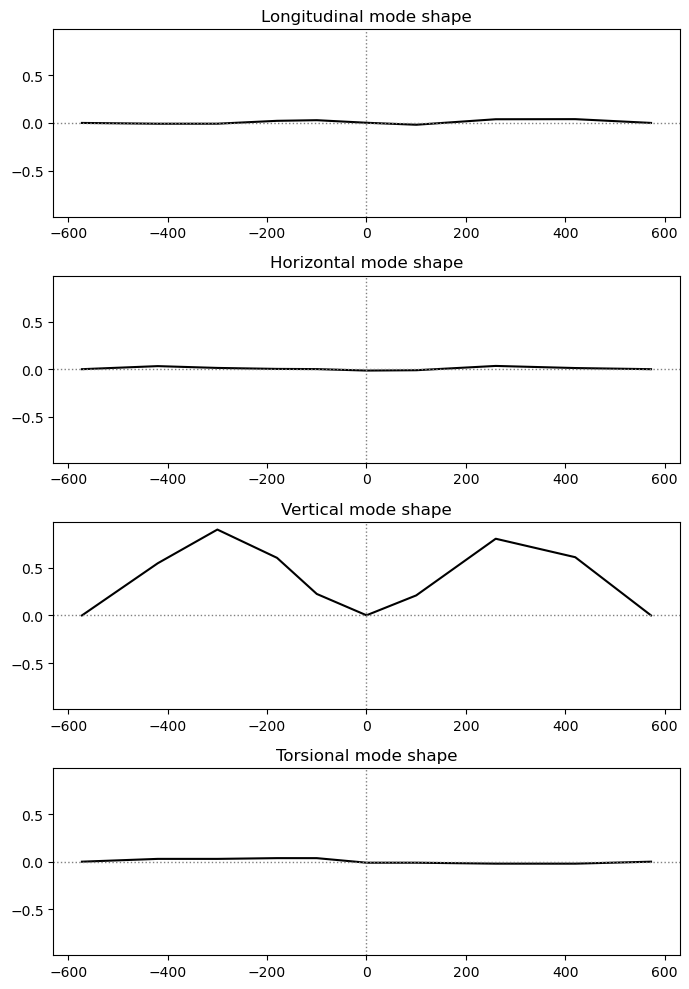

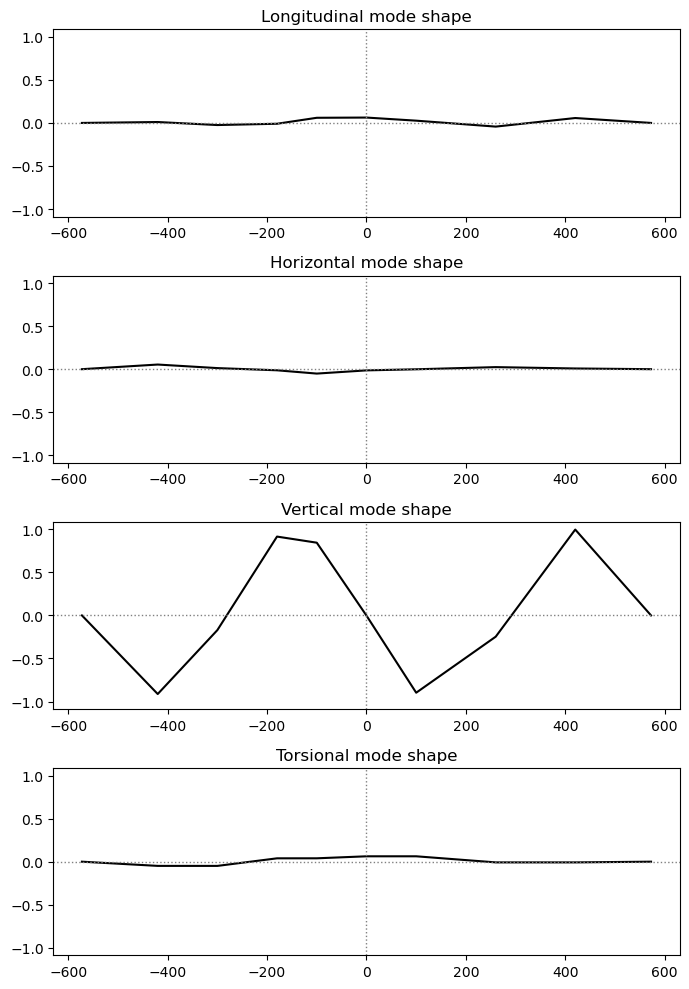

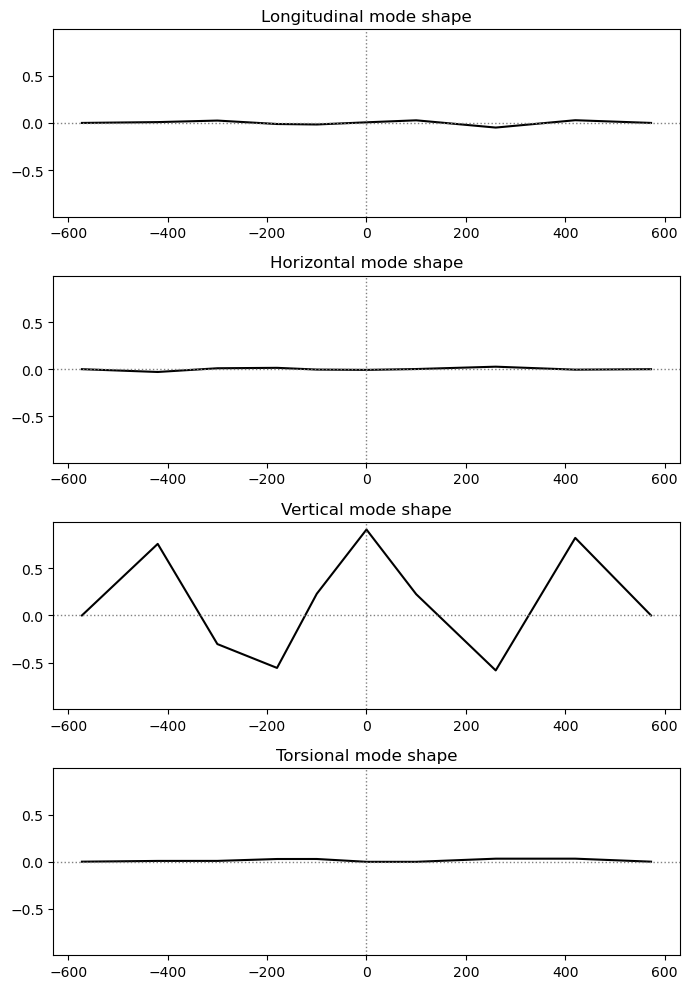

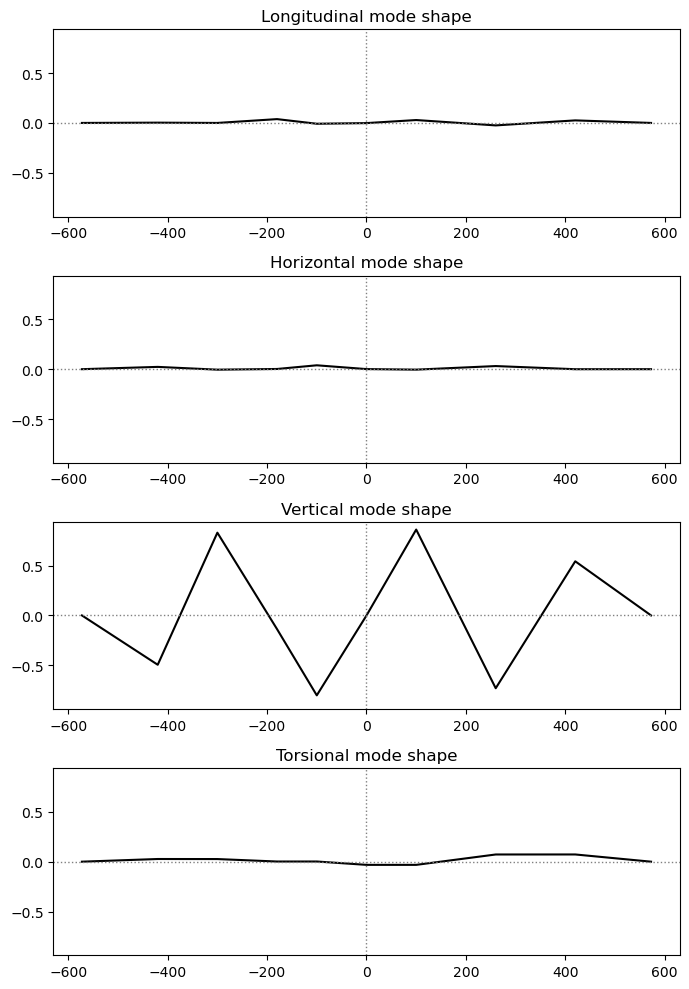

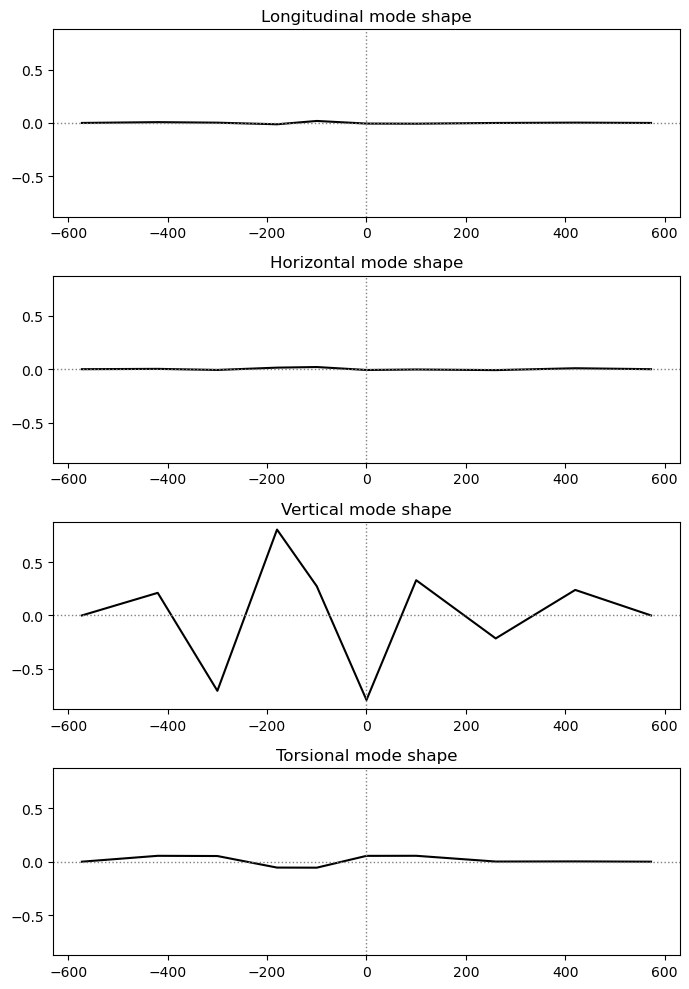

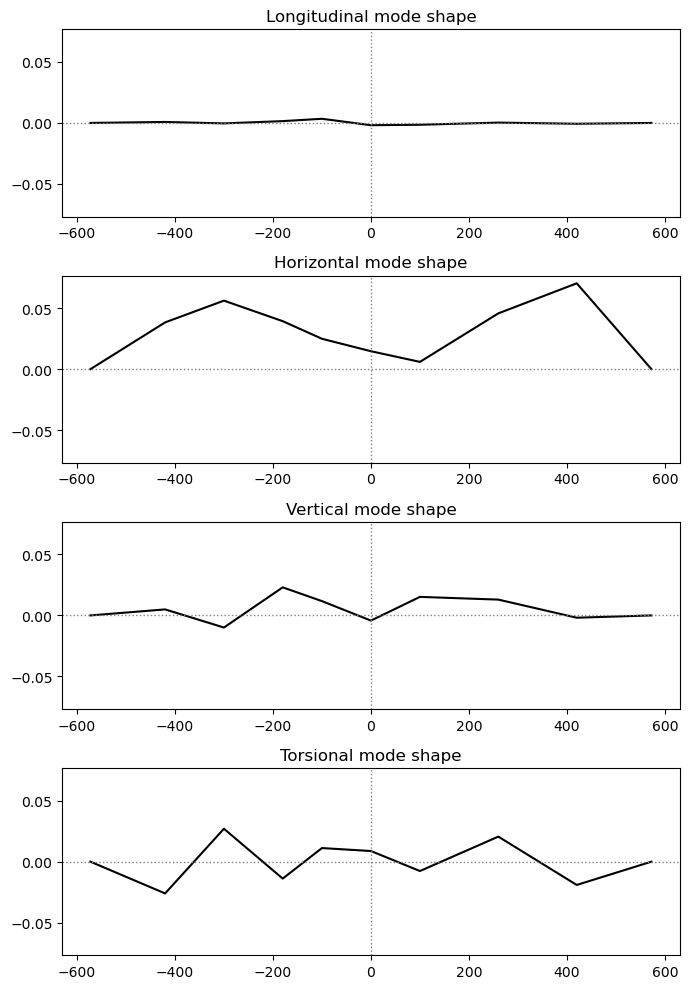

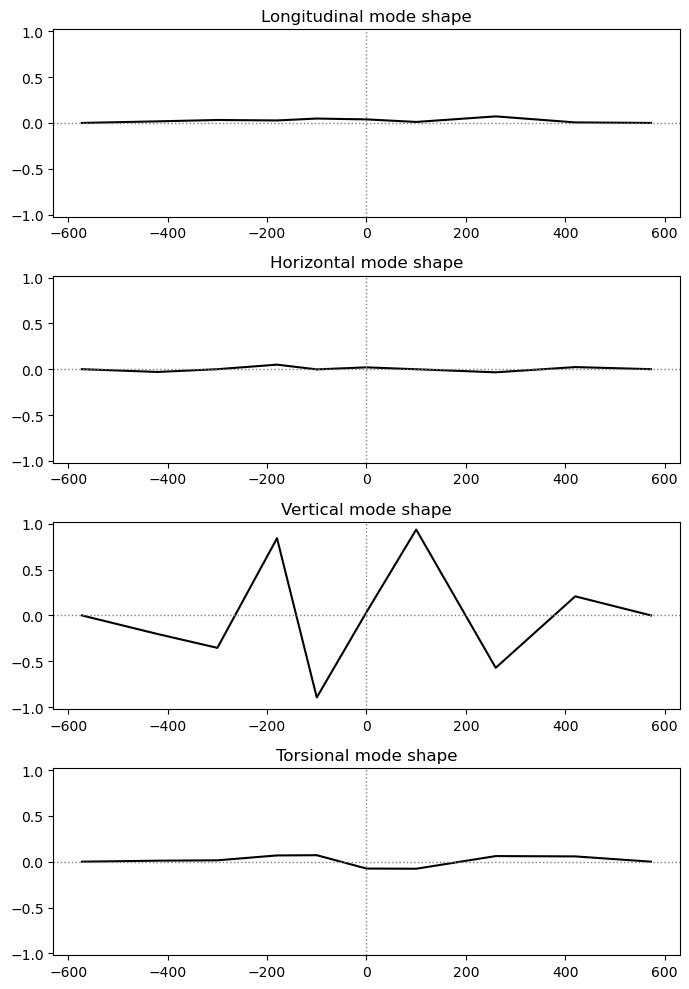

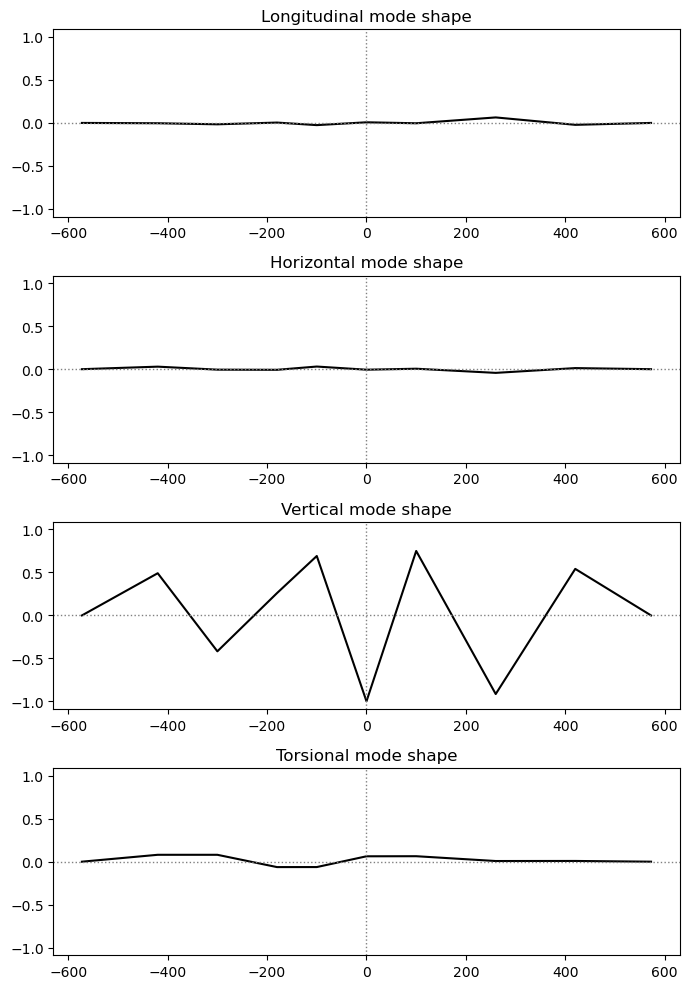

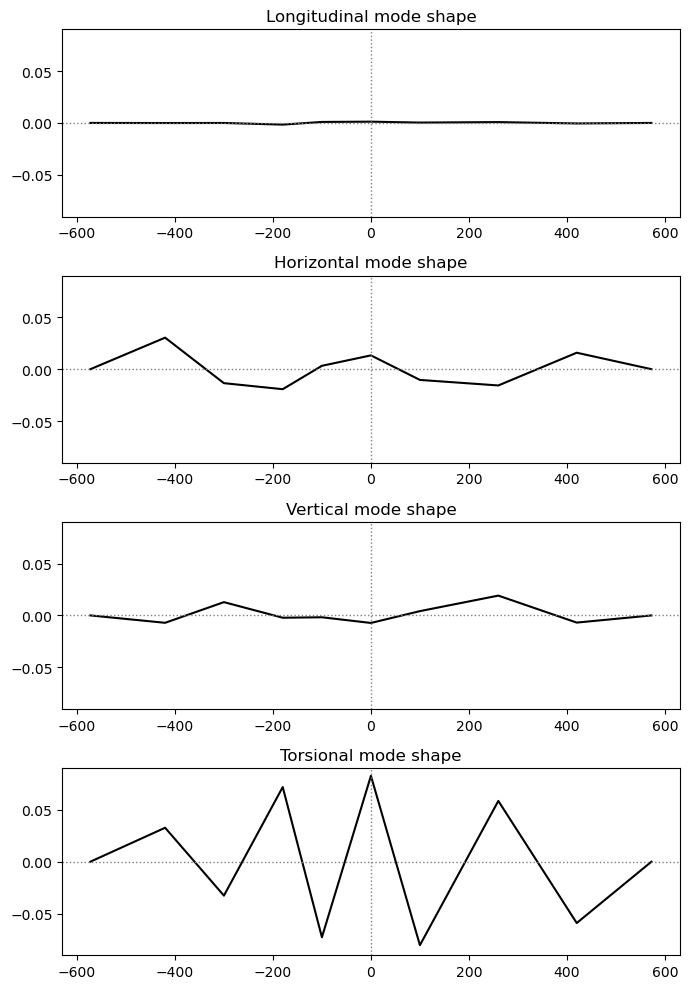

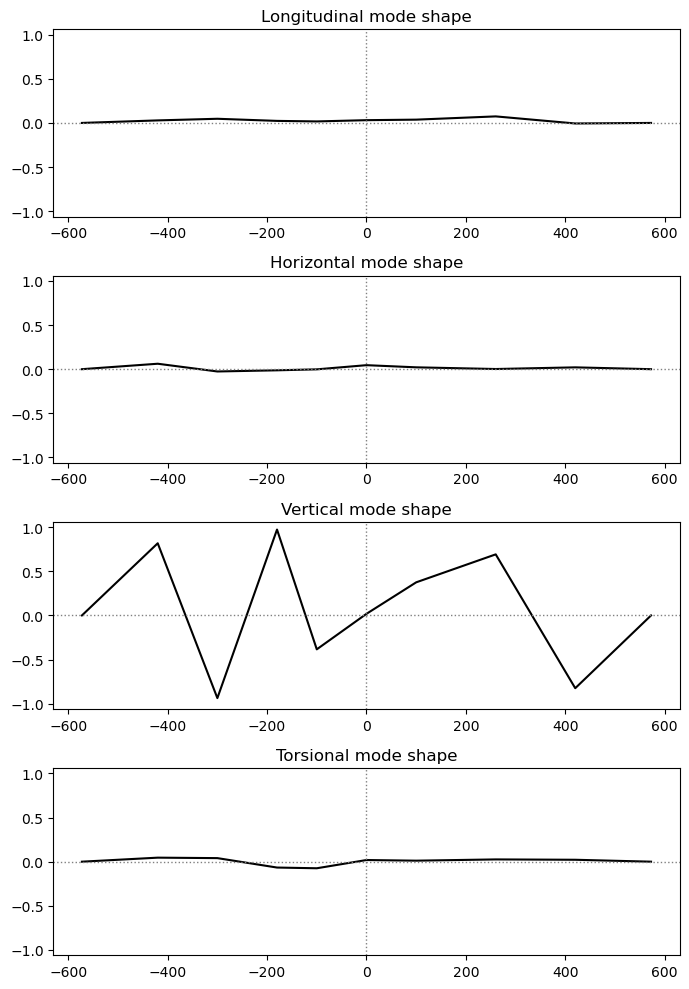

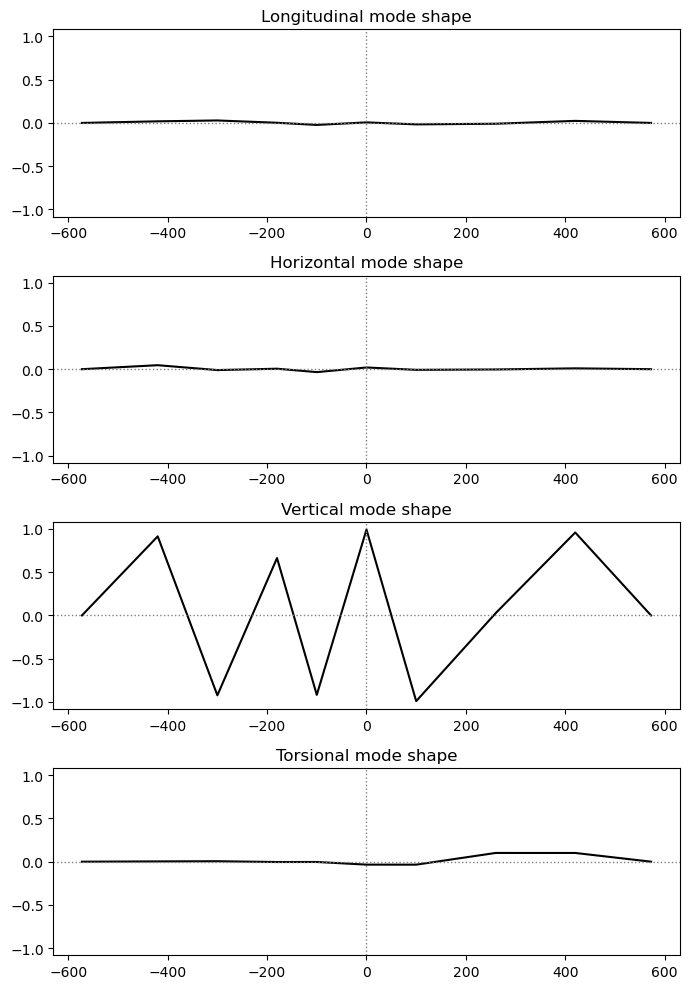

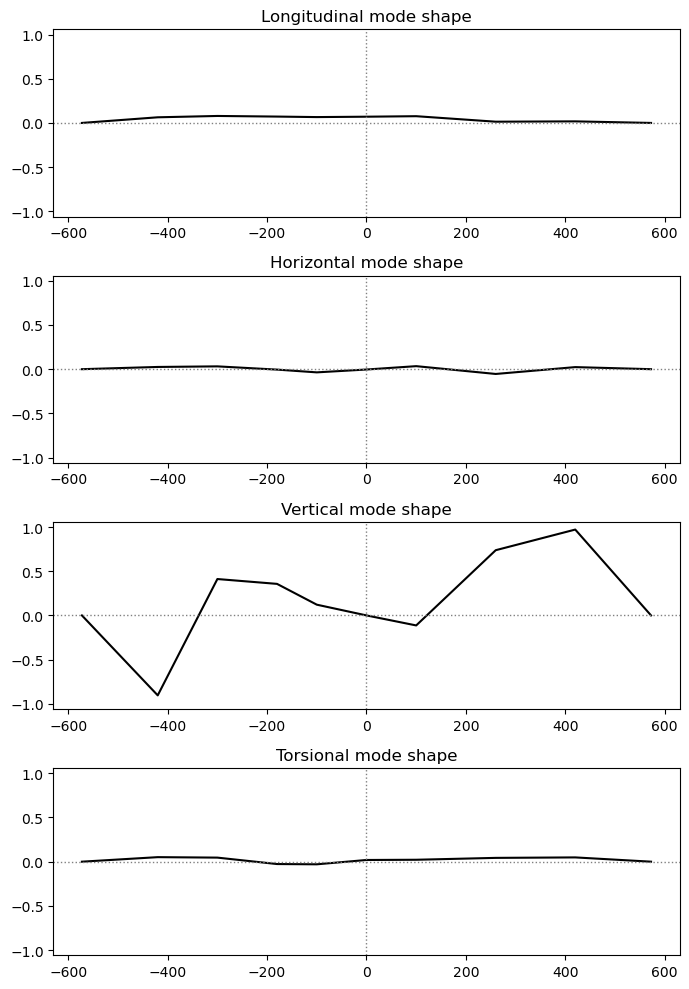

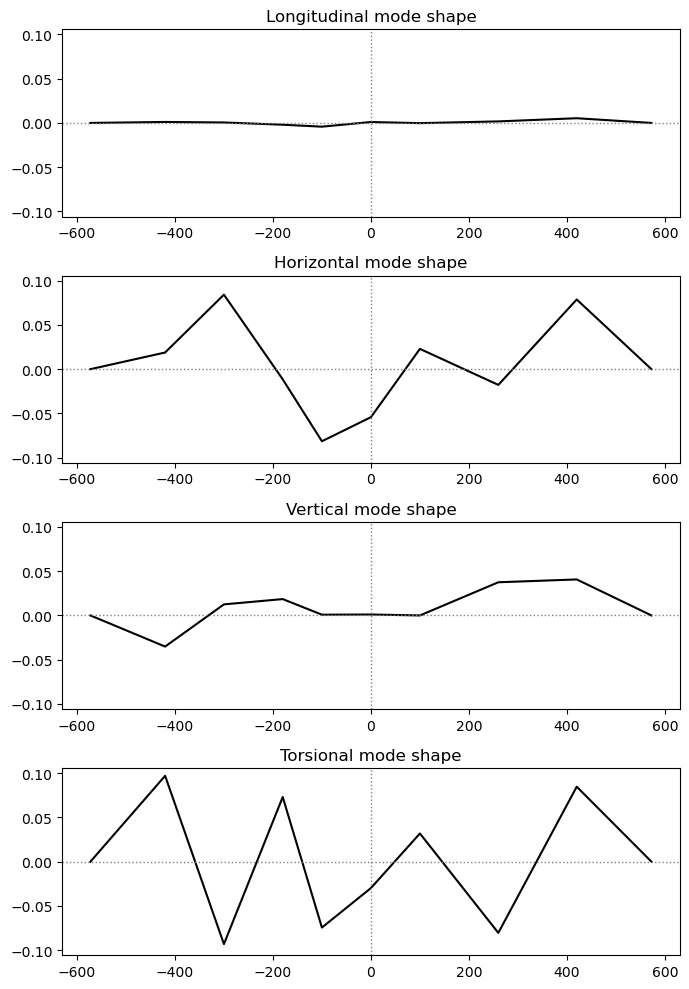

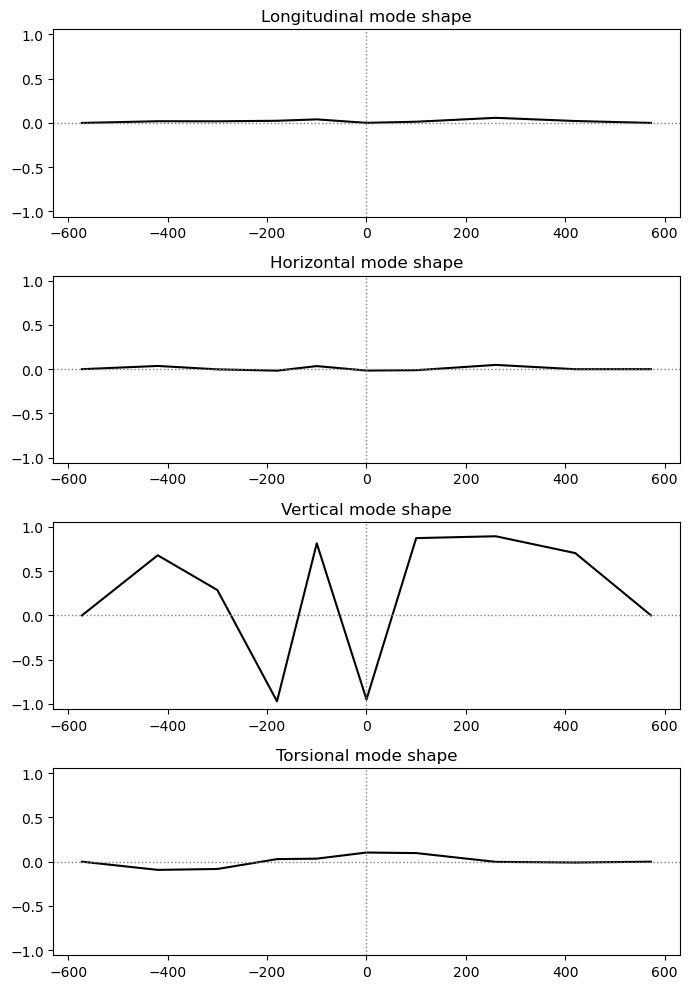

In [103]:
for i in range(phi_extracted.shape[1]):
    fig_shape = plotModeShape(phi_extracted, i)
    plt.savefig("plots/modeshapes/modeshape_mode_" + str(i+1) + ".jpg")